# Topic identification

In the following notebook, I try to identify the main topics in speeches of the German parliament.

## The libraries

In [1]:
from umap import UMAP  # non-linear dimensional reduction
import pandas as pd    # fun with tables
import numpy as np     # fun with matrices
import matplotlib.pyplot as plt  # basic plotting
import seaborn as sns            # advanced plotting

import nltk  # natural language processing
from nltk.stem.snowball import SnowballStemmer  # stem the words, ignore grammar
from nltk.tokenize import word_tokenize         # bag of words
from nltk.corpus import stopwords               # get rid of very common, uniformative words

from sklearn.feature_extraction.text import TfidfVectorizer  # weight words that are more specific more
from sklearn.decomposition import NMF                        # negative values in matrix factorizations are oldschool ;)

# prepare nltk
# nltk.download('punkt')
# nltk.download('stopwords')

/home/kevin/miniconda3/envs/bundestag_py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading the data

Each session of the parliament was parsed as a CSV file.
I want to have all the data in one table, hence I concatenate the CSV files into one pandas data frame.

In [2]:
from os import listdir
csv_files = [x for x in listdir('data/csv') if x.endswith('-data.csv')]
df = pd.concat( [pd.read_csv(f'data/csv/{x}') for x in csv_files] )
df.head()

Unnamed: 0    name given_name  speaker_id  \
0  ID201000100  Scholz       Olaf    11003231   
1  ID201000200    Frei   Thorsten    11004276   
2  ID201000300  Scholz       Olaf    11003231   
3  ID201000400    Frei   Thorsten    11004276   
4  ID201000500  Scholz       Olaf    11003231   

                                              conten                   top  \
0  Frau Präsidentin! Meine Damen und Herren! Die ...  Tagesordnungspunkt 1   
1  Herr Bundeskanzler, Sie haben jetzt in Ihren A...  Tagesordnungspunkt 1   
2  Schönen Dank für Ihre Frage und für die Gelege...  Tagesordnungspunkt 1   
3  Gerne. Dann mache ich davon Gebrauch. – Herr B...  Tagesordnungspunkt 1   
4  Als jemand, der diesem Parlament schon mehrere...  Tagesordnungspunkt 1   

   wahlperiode        date  
0           20  12.01.2022  
1           20  12.01.2022  
2           20  12.01.2022  
3           20  12.01.2022  
4           20  12.01.2022

## Data preprocessing

My preprocessing approach is to ignore context of the speech and treat each entry as a bag of words.
I assume that the main essence of a speech can be captured using this model.
Obviously, finer nuances are lost and sentiments might not be captured correctly.
To get rid variations of the same word due to grammar, I use the `SnowballStemmer` to stem each word.
Additionally I remove stopwords like er/sie/es or der/die/das.

In [3]:
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

In [4]:
def preprocess_text(text: str, 
                    do_stemming: bool = False, 
                    remove_stop: bool = False,
                    stemmer: nltk.stem.snowball.SnowballStemmer = None,
                    stopwords: set = None) -> str:
    '''
    Bag of words approach
    
    text: string = text to clean
    do_stemming: bool = whether to stem the words [False]
    remove_stop: bool = whether to remove stopwords [False]
    stemmer: SnowballStemmer = the stemmer instance to use [None]
    stopwords: set = list of stopwords to remove [None]
    
    Returns string of cleaned text
    '''
    import re
    # compiling the regular expressions for cleaning
    re_spaces = re.compile(r'\s+', re.IGNORECASE) # take care of whitespaces
    re_ascii = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE) # words only, please
    
    # apply above regular expression filters
    text = re.sub(re_spaces, ' ', text)
    text = re.sub(re_ascii, ' ', text)
    
    # and write everything lowercase
    text = text.lower()
    
    # tokenize the words
    tokens = word_tokenize(text)
    
    # remove stopwords, if needed
    if remove_stop and stopwords is not None:
        tokens = [token for token in tokens if token not in stopwords]
    
    # use the stem of each word, only
    if do_stemming and stemmer is not None:
        tokens = [stemmer.stem(token) for token in tokens] 
    
    # join the tokens to a string
    return(' '.join(tokens))

Now, we apply the preprocessing step to each speech:

In [5]:
df['clean_content'] = df['conten'].map(lambda x: preprocess_text(x, do_stemming=True, remove_stop=True, stemmer=stemmer, stopwords=stop_words))

And we have a look, how long each speech was:

In [6]:
df['n_stems'] = df['clean_content'].map(lambda x: len(x.split(' ')))

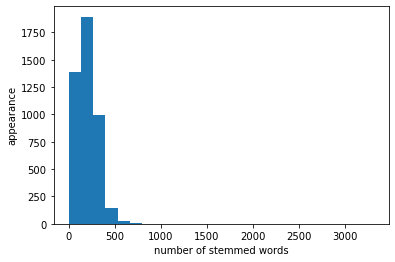

In [7]:
plt.hist(df['n_stems'], bins=25)
plt.xlabel('number of stemmed words')
plt.ylabel('appearance')
plt.show()

To remove very short contributions, where we don't expect a clear topic signal, we filter for speeches with more than 100 words.

In [8]:
df = df.loc[df['n_stems'] > 100].copy()

df.shape

(3388, 10)

About 3,400 speeches are still in the dataset.

In [9]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

Now, we transform the bag of words to a more useful format.
We apply term-frequency - inverse document frequency to the speeches.
This takes care of length differences between the speeches and also increases the weight for speech specific words.
To broaden the captured signal, I allow n-grams of up to two words to be treated as individual features.
We already removed stopwords, but political lingo has its own set of frequent words without any meaning for our current analysis.
Therefore, we set the maximum document frequency to `0.3` which more stringently removes common words.
This might also remove overarching topics by filtering out those words, but this is a caveate we accept for now.

In [10]:
vectorizer = TfidfVectorizer(max_df=0.3, min_df=.01, ngram_range=(1,2))

In [11]:
vectorizer.fit(df['clean_content'])
X = vectorizer.transform(df['clean_content'])
X.shape

(3388, 3193)

After we got the speeches transformed to TF-IDF values, we can apply a matrix factorization to the data.
The goal here is to identify latent variables and see the loading per variable of each speech.
This captures the nature of speeches, which don't need to be attributed exclusively to one topic only.
I chose non-negative matrix factorization since it is known (e.g. [Hassani et al. 2021](https://link.springer.com/article/10.1007/s00521-021-06014-6) to capture good results when working with sparse text-based data.
To get started we set the number of latent features (topics) to `25`.

In [12]:
no_topics = 25
nmf = NMF(n_components=no_topics, 
          alpha_H=0, 
          alpha_W=0, 
          random_state=1, 
          l1_ratio=.5, init='nndsvd',
          max_iter=400).fit(X)
# nmf = LatentDirichletAllocation(n_components=no_topics, random_state=1).fit(X)

Let's have a look at the top-scoring words per identified topic.
For many it is very easy to see the topic per latent variable.
Sometimes it is harder to guess what signal was captured - e.g. topic 0 seems to capture discussion wording in general.
Topic 1 is the ongoing war between Ukraine and Russia.

In [13]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print( f'Topic {topic_idx}:' )
        print( " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 50
tfidf_feature_names = vectorizer.get_feature_names_out()
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
gesagt thema gesetzentwurf desweg gesetz glaub hatt punkt tun wirklich debatt red darub find eigent word gemacht woch einfach vielleicht situation vorschlag darauf bundestag war ding tag moglich fdp namlich wiss tatsach gern seh warum geh geb bissch lag deutlich drei ubrig koalition end gar nach zweit verantwort diskuti sprech

Topic 1:
ukrain russland putin krieg russisch nato waff sanktion militar bundeskanzl tag angriffskrieg unterstutz freiheit europa fried prasident verteid finnland waffenliefer schwed volk butscha west lief aussenpolit angriff konflikt woch volkerrechtswidr wladimir wladimir putin volkerrecht mensch ukrain russland ukrain partn kriegsverbrech usa krieg ukrain welt geschicht international steh brutal demokrati kiew gemeinsam interess bundnis entscheid

Topic 2:
impfpflicht impfung impf pandemi impfstoff allgemein impfpflicht allgemein geimpft omikron covid variant virus schutz schwer ungeimpft herb einrichtungsbezog einrichtungsbezog impfpflicht impf lass

## Projection to two dimensions
Now, we transform the data so we can use the latent space to further reduce the dimensionality:

In [14]:
X_nmf = nmf.transform(X)

In [15]:
X_nmf.shape

(3388, 25)

Comming from bioinformatics, [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) developed into the go-to-tool for non-linear low dimensional embedding.
Let's see how it performes on the NMF output.

In [16]:
um = UMAP(metric='hellinger', 
          n_components=2,
          min_dist=.15,
          n_neighbors=15)

x_umap = um.fit_transform(X)

We visualize the UMAP, where each speech is represented as a point on the scatter plot.
We color each speech accoring to its latent variable weight for the topic, capturing the war between Ukraine and Russia.

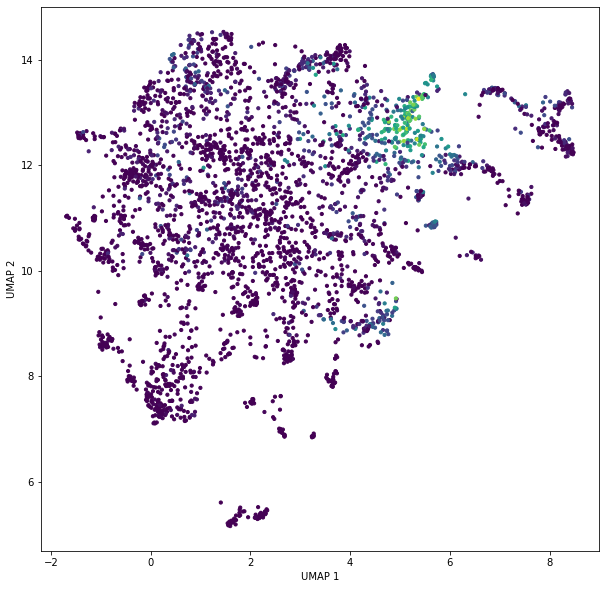

In [17]:
plt.figure(figsize = (10,10))
plt.scatter(
    x_umap[:,0],
    x_umap[:,1],
    c = X_nmf[:,1],
    s = 10
)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

As expected, speeches focusing on the Ukraine - Russia war cluster together.
In general various clusters can be seen which capture the majority of topics.
A deeper analysis of this is needed.

## Qualitative time dependence

We will now have a look whether different topics show some kind of co-occurence and whether some identified topics have a expected time dependence. 
For the sake of simplicity, we will have a look at the afore mentioned Ukraine - Russia war.

First off, we add the topics to the speech data frame:

In [18]:
for i in range(0, X_nmf.shape[1]):
    df[f'topic_{i}'] = X_nmf[:,i]

Since topic loadings are non-centered and non-scaled and we want to compare them, we apply z-scoring to them.

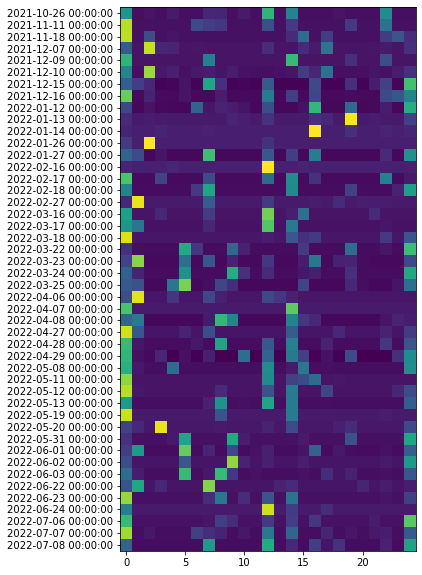

In [19]:
def scale_values(x: np.ndarray) -> np.ndarray:
    '''
    Apply z-scoring to the provided vector
    '''
    x = x - x.mean()
    return x/x.std()

median_by_date = df.groupby('date').median()
median_by_date = median_by_date.iloc[:,median_by_date.columns.str.startswith('topic')]
median_by_date = median_by_date.sort_index()
median_by_date = median_by_date.apply(scale_values, axis = 1)

plt.figure( figsize = (10,10) )
plt.yticks(ticks = range(0, median_by_date.shape[0]),
           labels = median_by_date.index)
plt.imshow(median_by_date) 

Russia invaded Ukraine at the 24th of February, the first session of the parliament after the attack was on the 27th of February.
We can clearly see that this date as one of the highest z-score for topic 1!

Now, we cluster the topics and see whether we can find clusters of topics that co-occur.

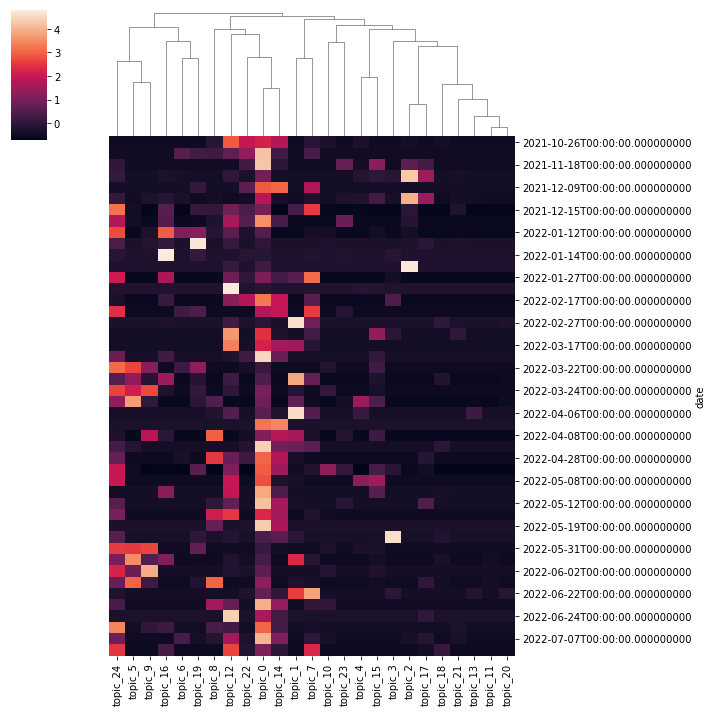

In [20]:
sns.clustermap(median_by_date, 
               z_score=None, 
               row_cluster=False,
              metric='correlation');

The clearest cluster captures topics 5, 9 and 24. 
All of these topics are financial and economic centered.

Adjacent are topics 6, 16 and 19 which capture climate and habitation which are closely related in Germany, due to discussion on how to improve the climate footprint of newly build homes and how to get rid of fossil fuels to heat our homes.

The other hierarchical clusters are more complicated to interpret and need further study.

## Discussion

Using TF-IDF and NMF we could identify topics for speeches at the German parliament.
We were able to identify clusters of similar speeches and a qualitative time dependency of some topics.

Further analysis is needed to mine all the data within the dataset.
Some things we can try in the future:

- more stringent topic clustering
- Leiden algorithm based clustering of speeches
- topic loading per political party
- Bayesian modelling of topic time series data

In [21]:
!mamba list


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.15.3) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

# packages in environment at /home/kevin/miniconda3/envs/bundestag_py:
#
# Name                    Version       